tobac example: Tracking of deep convection based on OLR from convection permitting model simulations
==
This example notebook demonstrates the use of tobac to track deep convection based on the outgoing longwave radiation (OLR) from convection permitting simulations. This is a legacy example, showing how iris cube input can still be used after the shift to xarray as the core data model in tobac v1.6

The simulation results used in this example were performed as part of the ACPC deep convection intercomparison  case study (http://acpcinitiative.org/Docs/ACPC_DCC_Roadmap_171019.pdf) with WRF using the Morrison microphysics scheme. Simulations were performed with a horizontal grid spacing of 4.5 km.

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

**Import libraries:**

In [1]:
# Import a range of python libraries used in this notebook:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import shutil
import datetime
from six.moves import urllib
from pathlib import Path
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.6.2


In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Download example data:**  
The actual download is only necessary once for all example notebooks.


In [4]:
data_out=Path('../')

In [5]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob('data/Example_input_OLR_model.nc'))
if len(data_file) == 0:
    file_path='https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
    #file_path='http://zenodo..'
    tempfile=Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_path, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print('data extracted')
    data_file = list(data_out.rglob('data/Example_input_OLR_model.nc'))

In [6]:
#Load Data from downloaded file:
OLR=iris.load_cube(str(data_file[0]),'OLR')

In [7]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

**Feature detection:**  
Feature detection is performed based on OLR field and a set of thresholds.

In [8]:
# Determine temporal and spatial sampling:
dxy,dt=tobac.get_spacings(OLR)

In [9]:
# Dictionary containing keyword arguments for feature detection step (Keywords could also be given directly in the function call).
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['n_min_threshold']=4
parameters_features['target']='minimum'
parameters_features['threshold']=[250,225,200,175,150]

In [10]:
# Perform feature detection:
print('starting feature detection')
Features=tobac.feature_detection_multithreshold(OLR,dxy, **parameters_features)
Features.to_hdf(savedir / 'Features.h5', 'table')
print('feature detection performed and saved')

starting feature detection


feature detection performed and saved


**Segmentation:**  
Segmentation is performed with watershedding based on the detected features and a single threshold value.

In [11]:
# Dictionary containing keyword options for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=250

In [12]:
# Perform segmentation and save results:
print('Starting segmentation based on OLR.')
Mask_OLR,Features_OLR=tobac.segmentation_2D(Features,OLR,dxy,**parameters_segmentation)
print('segmentation OLR performed, start saving results to files')
iris.save([Mask_OLR], savedir / 'Mask_Segmentation_OLR.nc', zlib=True, complevel=4)                
Features_OLR.to_hdf(savedir / 'Features_OLR.h5', 'table')
print('segmentation OLR performed and saved')

Starting segmentation based on OLR.


segmentation OLR performed, start saving results to files
segmentation OLR performed and saved


**Trajectory linking:**  
Features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.**

In [13]:
# Arguments for trajectory linking:
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=0
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [14]:
# Perform linking and save results to file:
Track=tobac.linking_trackpy(Features, OLR, dt=dt, dxy=dxy, **parameters_linking)
Track.to_hdf(savedir / 'Track.h5', 'table')

Frame 95: 12 trajectories present.


**Visualisation:**

In [15]:
# Set extent of maps created in the following cells:
axis_extent = [-95, -89, 28, 32]        

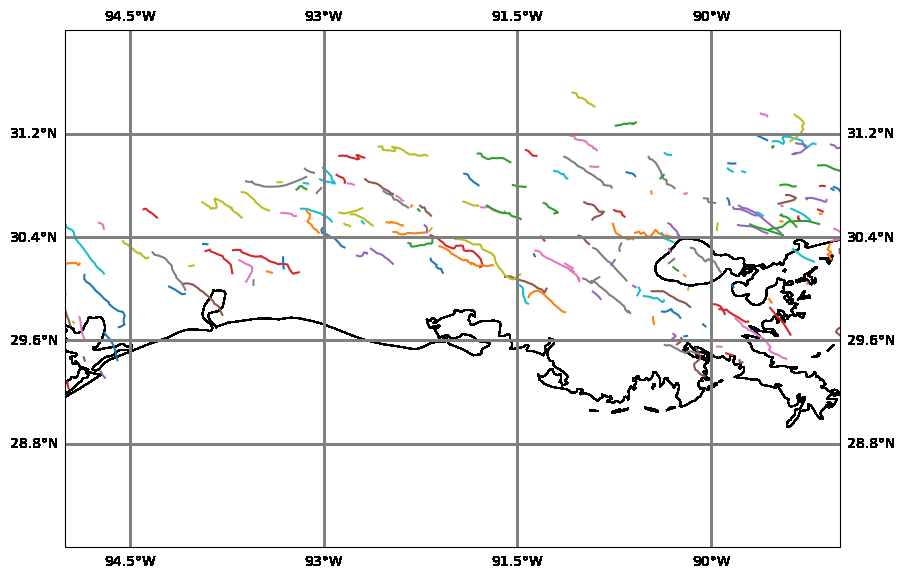

In [16]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map, ax_map = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax_map = tobac.map_tracks(Track, axis_extent=axis_extent,  axes=ax_map)

In [17]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.animation_mask_field(Track,Features,OLR,Mask_OLR,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=80,vmax=330,
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

In [18]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>

In [19]:
# # Save animation to file:
# savefile_animation = plot_dir /'Animation.mp4'
# animation_test_tobac.save(savefile_animation,dpi=200)
# print(f'animation saved to {savefile_animation}')

Text(0, 0.5, 'counts')

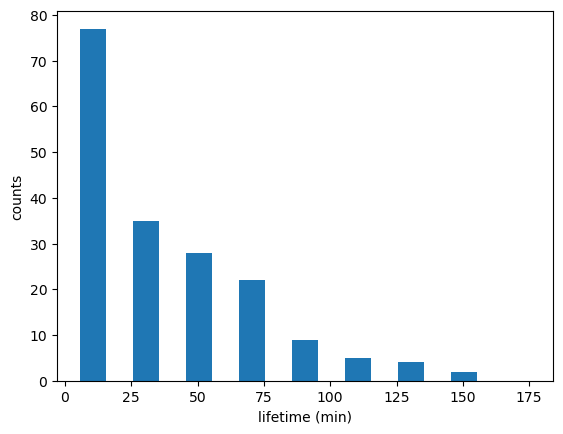

In [20]:
# Lifetimes of tracked clouds:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,200,20),density=False,width_bar=10)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         